In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [2]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('ffinal_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [4]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [5]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [6]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [7]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [8]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
1,0.999966667777741,0.749981250468738,0.66664444518516,0.499987500312492,0.833319444675922,0.624992187597655,0.0,1.0,2.0,7.0,...,3,34,45,6,8,4.0,14.0,0.285714285714286,5,1
2,0.444439506227709,0.363633057881292,0.33332222259258,0.111109876556927,0.277776234576475,0.26315650970258,0.0,0.0,1.0,18.5,...,22,86,81,18,18,5.0,32.0,0.15625,25,19
3,0.249993750156246,0.090908264470323,0.749990625117186,0.545449586821938,0.499996428596939,0.304346502841292,1.0,0.0,9.0,18.5,...,1,80,128,14,21,7.0,33.0,0.212121212121212,2,0
4,0.749981250468738,0.599988000239995,0.0,0.0,0.428565306209911,0.428565306209911,0.0,0.0,0.0,7.0,...,1,48,53,7,7,2.0,14.0,0.142857142857143,2,0
5,0.499987500312492,0.499987500312492,0.199996000079998,0.199996000079998,0.333329629670781,0.333329629670781,1.0,0.0,0.0,9.0,...,2,61,49,9,9,3.0,18.0,0.166666666666667,4,0


<h2> 4.2 Converting strings to numerics </h2>

In [9]:
data=data.astype(np.float64)

In [10]:
data

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
1,0.999967,0.749981,0.666644,0.499988,0.833319,0.624992,0.0,1.0,2.0,7.0,...,3.0,34.0,45.0,6.0,8.0,4.0,14.0,0.285714,5.0,1.0
2,0.444440,0.363633,0.333322,0.111110,0.277776,0.263157,0.0,0.0,1.0,18.5,...,22.0,86.0,81.0,18.0,18.0,5.0,32.0,0.156250,25.0,19.0
3,0.249994,0.090908,0.749991,0.545450,0.499996,0.304347,1.0,0.0,9.0,18.5,...,1.0,80.0,128.0,14.0,21.0,7.0,33.0,0.212121,2.0,0.0
4,0.749981,0.599988,0.000000,0.000000,0.428565,0.428565,0.0,0.0,0.0,7.0,...,1.0,48.0,53.0,7.0,7.0,2.0,14.0,0.142857,2.0,0.0
5,0.499988,0.499988,0.199996,0.199996,0.333330,0.333330,1.0,0.0,0.0,9.0,...,2.0,61.0,49.0,9.0,9.0,3.0,18.0,0.166667,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.0,8.5,...,2.0,68.0,41.0,11.0,7.0,0.0,18.0,0.000000,3.0,1.0
99997,0.499988,0.499988,0.749981,0.428565,0.624992,0.454541,1.0,1.0,3.0,9.5,...,5.0,42.0,49.0,8.0,11.0,5.0,19.0,0.263158,10.0,0.0
99998,0.799984,0.799984,0.999980,0.999980,0.899991,0.899991,0.0,1.0,0.0,10.0,...,2.0,55.0,54.0,10.0,10.0,8.0,20.0,0.400000,4.0,0.0
99999,0.333322,0.249994,0.666644,0.399992,0.428565,0.374995,0.0,1.0,1.0,7.5,...,5.0,40.0,37.0,9.0,7.0,3.0,16.0,0.187500,17.0,7.0


In [12]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [13]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3, random_state=42)

In [14]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 26)
Number of data points in test data : (30000, 26)


In [15]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6329428571428571 Class 1:  0.36705714285714286
---------- Distribution of output variable in train data ----------
Class 0:  0.36706666666666665 Class 1:  0.36706666666666665


In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Performing Tfidf Vecorization

In [17]:
df=pd.read_csv('train.csv')

In [18]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [19]:
xtrq1=[]
xtrq2=[]
for i in X_train.index:
    xtrq1.append(df.loc[i]['question1'])
    xtrq2.append(df.loc[i]['question2'])

In [20]:
X_train['question1']=xtrq1
X_train['question2']=xtrq2

In [21]:
xteq1=[]
xteq2=[]
for i in X_test.index:
    xteq1.append(df.loc[i]['question1'])
    xteq2.append(df.loc[i]['question2'])

In [22]:
X_test['question1']=xteq1
X_test['question2']=xteq2

In [23]:
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [24]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
from tqdm import tqdm
nlp = spacy.load('en')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)


100%|██████████| 70000/70000 [12:46<00:00, 91.35it/s]


In [25]:
vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

100%|██████████| 70000/70000 [12:42<00:00, 91.80it/s]


In [26]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)


100%|██████████| 30000/30000 [05:27<00:00, 91.62it/s]


In [27]:
vecs2 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)

100%|██████████| 30000/30000 [05:27<00:00, 91.69it/s]


In [28]:
xtr_q1=pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
xtr_q1=xtr_q1.add_suffix('_1')

In [29]:
xtr_q2=pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)
xtr_q2=xtr_q2.add_suffix('_2')

In [30]:
xte_q1=pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
xte_q1=xte_q1.add_suffix('_1')

In [31]:
xte_q2=pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)
xte_q2=xte_q2.add_suffix('_2')

In [32]:
X_train  = X_train.iloc[:,0:26].join(xtr_q1)
X_train  = X_train.join(xtr_q2)

In [33]:
X_train

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_2,87_2,88_2,89_2,90_2,91_2,92_2,93_2,94_2,95_2
93529,0.499988,0.249997,0.000000,0.000000,0.499988,0.181817,0.0,0.0,7.0,7.5,...,-10.154725,1.762139,-16.755479,110.832014,11.372895,-13.905192,-13.568532,2.341643,-2.458623,53.761967
99939,0.499988,0.499988,0.666644,0.499988,0.571420,0.499994,0.0,1.0,1.0,7.5,...,-44.749943,-19.873879,13.053786,14.794653,-71.493776,-25.953699,16.311391,35.314439,50.748092,42.322499
38384,0.999950,0.999950,0.599988,0.599988,0.624992,0.555549,0.0,0.0,1.0,8.5,...,-19.276710,47.667434,-19.514092,17.425847,-41.997759,-17.158165,-65.441865,39.866055,41.655490,41.061198
69115,0.749981,0.599988,0.499992,0.499992,0.599994,0.545450,0.0,0.0,1.0,10.5,...,-13.670354,-11.451509,-28.246991,36.236756,-51.921170,55.016888,42.651534,16.371245,30.587365,23.951154
84297,0.799984,0.571420,0.666644,0.499988,0.666659,0.599994,0.0,0.0,1.0,9.5,...,-1.700355,-13.007062,-66.551932,31.816506,-13.043107,18.392902,18.616472,92.230206,116.664021,21.234317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84307,0.333322,0.142855,0.249994,0.249994,0.249997,0.181817,1.0,1.0,3.0,9.5,...,10.730155,62.710107,-116.911562,54.878194,-60.124144,-45.457296,19.571698,316.427019,210.153287,110.448615
12923,0.666656,0.333331,0.545450,0.428568,0.555552,0.357142,0.0,0.0,10.0,23.0,...,-2.969839,-3.109329,-39.289508,12.569095,13.093356,-32.776173,-8.137590,41.239925,-30.186907,34.688756
38123,0.399992,0.199998,0.999967,0.299997,0.624992,0.227272,0.0,0.0,14.0,15.0,...,-10.871909,-0.280905,-13.793900,58.195398,-41.613721,-49.151977,7.187565,46.048589,32.771241,25.486844
53009,0.000000,0.000000,0.199998,0.199998,0.117646,0.090909,0.0,0.0,5.0,19.5,...,-16.540089,-50.365400,-46.003112,69.503715,43.387033,53.557927,8.514708,176.846094,159.441346,69.646738


In [34]:
X_test  = X_test.iloc[:,0:26].join(xte_q1)
X_test  = X_test.join(xte_q2)

In [35]:
X_test

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_2,87_2,88_2,89_2,90_2,91_2,92_2,93_2,94_2,95_2
94729,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,7.0,6.5,...,-0.888098,9.772911,0.619955,3.472036,-10.568639,-2.677975,-3.868487,0.829163,1.006087,6.117448
56007,0.499988,0.499988,0.999975,0.999975,0.749991,0.666659,1.0,1.0,1.0,8.5,...,140.429168,-97.054628,-58.898803,48.928532,-59.958845,37.913445,95.067590,172.424797,43.905775,123.637901
72942,0.666644,0.666644,0.999980,0.999980,0.874989,0.874989,0.0,1.0,0.0,8.0,...,-29.991429,-29.831682,-22.148497,-7.799621,-66.746491,-12.599275,34.540393,62.282822,29.419903,12.013201
93525,0.499988,0.333328,0.666644,0.333328,0.571420,0.333331,1.0,1.0,5.0,9.5,...,-11.698000,6.969487,8.138780,27.177179,-36.561431,-15.648715,-48.565743,4.230834,36.461697,-20.954127
51215,0.999975,0.666656,0.999980,0.714276,0.999989,0.642853,1.0,1.0,5.0,11.5,...,-26.494618,-65.366066,15.985776,3.073878,-73.327209,37.201668,-38.560402,2.233924,29.798255,1.382742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354,0.199998,0.181817,0.444440,0.399996,0.299999,0.239999,0.0,0.0,5.0,22.5,...,-16.096273,6.478574,-8.372487,7.576180,-55.541819,-39.919392,41.532080,42.681034,4.836793,48.461678
59528,0.599988,0.499992,0.399992,0.399992,0.499995,0.454541,0.0,1.0,1.0,10.5,...,10.533102,17.552120,4.555197,9.960984,-7.512094,54.756586,-5.307025,24.322918,9.468559,26.548701
48458,0.999950,0.666644,0.999975,0.999975,0.999983,0.857131,1.0,1.0,1.0,6.5,...,-27.622618,49.010536,-20.770476,13.630758,-12.574470,-0.037209,-13.707195,5.749172,-16.502031,71.078059
83331,0.666644,0.666644,0.333322,0.249994,0.499992,0.428565,0.0,0.0,1.0,6.5,...,-36.521557,-18.633851,-46.755533,10.366529,-68.973825,-35.003876,0.130892,84.637365,17.532860,18.075095


<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8841695540401169


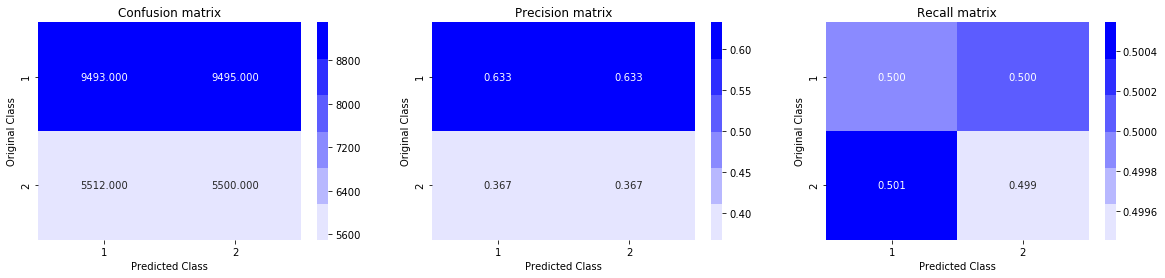

In [36]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4913585352413461
For values of alpha =  0.0001 The log loss is: 0.47055604756056096
For values of alpha =  0.001 The log loss is: 0.465436395862282
For values of alpha =  0.01 The log loss is: 0.4720589783366813
For values of alpha =  0.1 The log loss is: 0.4583744128314124
For values of alpha =  1 The log loss is: 0.4966605419031387
For values of alpha =  10 The log loss is: 0.530333418800116


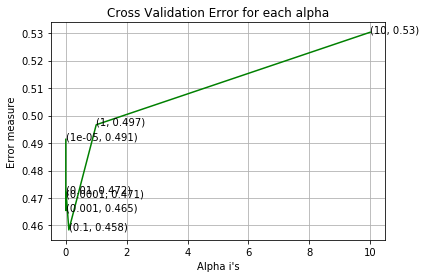

For values of best alpha =  0.1 The train log loss is: 0.45559952329856157
For values of best alpha =  0.1 The test log loss is: 0.4583744128314124
Total number of data points : 30000


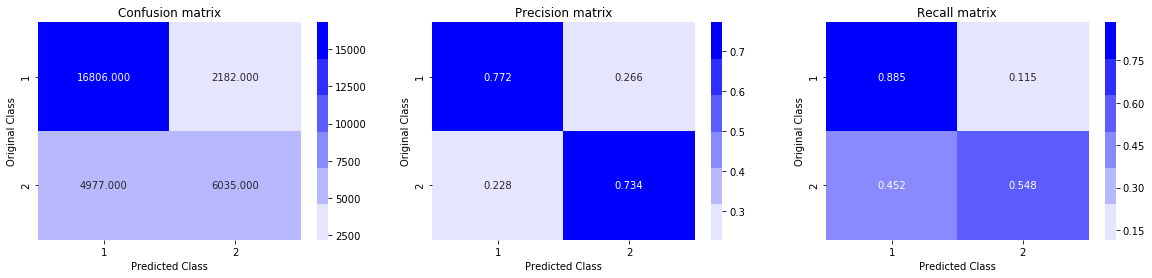

In [37]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6573760347277865
For values of alpha =  0.0001 The log loss is: 0.6573760347277865
For values of alpha =  0.001 The log loss is: 0.6573760347277865
For values of alpha =  0.01 The log loss is: 0.4895117652120274
For values of alpha =  0.1 The log loss is: 0.5500012140435878
For values of alpha =  1 The log loss is: 0.5871313220066511
For values of alpha =  10 The log loss is: 0.6491321283879256


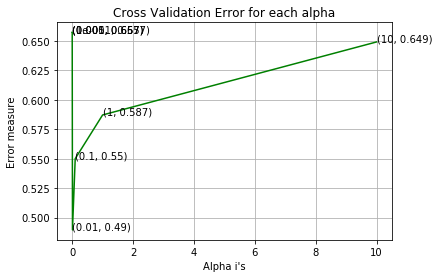

For values of best alpha =  0.01 The train log loss is: 0.4915569981536748
For values of best alpha =  0.01 The test log loss is: 0.4895117652120274
Total number of data points : 30000


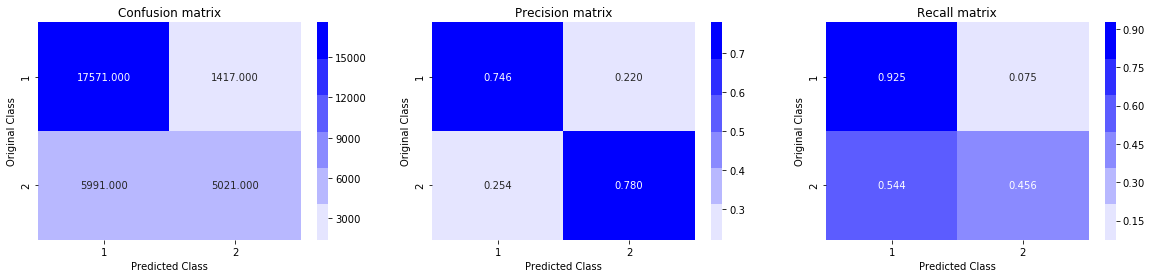

In [38]:
warnings.filterwarnings("ignore")
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [167]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.6847	valid-logloss:0.684848
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.614092	valid-logloss:0.614877
[20]	train-logloss:0.562696	valid-logloss:0.563868
[30]	train-logloss:0.523988	valid-logloss:0.525531
[40]	train-logloss:0.494081	valid-logloss:0.496003
[50]	train-logloss:0.470868	valid-logloss:0.473107
[60]	train-logloss:0.452324	valid-logloss:0.454728
[70]	train-logloss:0.437458	valid-logloss:0.440196
[80]	train-logloss:0.425504	valid-logloss:0.42846
[90]	train-logloss:0.415773	valid-logloss:0.418716
[100]	train-logloss:0.407645	valid-logloss:0.410614
[110]	train-logloss:0.400966	valid-logloss:0.404114
[120]	train-logloss:0.395454	valid-logloss:0.398633
[130]	train-logloss:0.390617	valid-logloss:0.393912
[140]	train-logloss:0.386667	valid-logloss:0.390043
[150]	train-logloss:0.383151	valid-logloss:0.386709
[160]	train-logloss:0.380119	va

Total number of data points : 30000


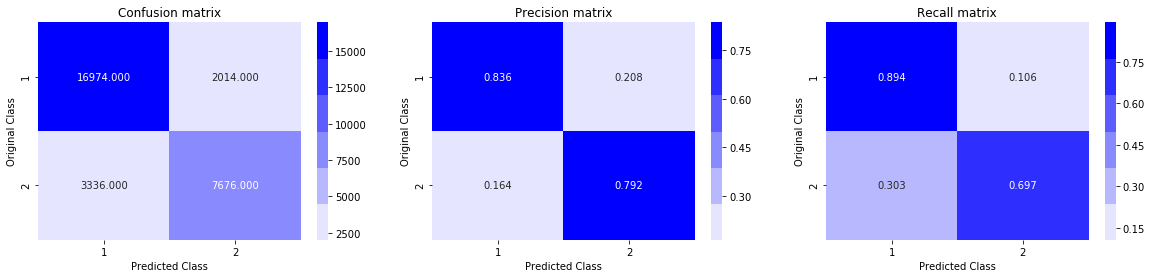

In [40]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Perform hyperparameter tuning  of XgBoost models using RandomsearchCV with vectorizer as TF-IDF W2V  to reduce the log-loss.



In [41]:
questions = xtrq1+xtrq2

xtfidf = TfidfVectorizer(lowercase=False, )
xtfidf.fit(questions)
xtrtfv1=xtfidf.transform(xtrq1)
xtrtfv2=xtfidf.transform(xtrq2)
xtetfv1=xtfidf.transform(xteq1)
xtetfv2=xtfidf.transform(xteq2)

In [42]:
print(xtrtfv1.shape)
print(xtrtfv2.shape)
print(xtetfv1.shape)
print(xtetfv2.shape)

(70000, 47790)
(70000, 47790)
(30000, 47790)
(30000, 47790)


In [79]:
X_train.iloc[:,0:26]

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
93529,0.499988,0.249997,0.000000,0.000000,0.499988,0.181817,0.0,0.0,7.0,7.5,...,1.0,28.0,61.0,4.0,11.0,2.0,15.0,0.133333,2.0,0.0
99939,0.499988,0.499988,0.666644,0.499988,0.571420,0.499994,0.0,1.0,1.0,7.5,...,3.0,44.0,50.0,7.0,8.0,4.0,15.0,0.266667,4.0,2.0
38384,0.999950,0.999950,0.599988,0.599988,0.624992,0.555549,0.0,0.0,1.0,8.5,...,1.0,36.0,40.0,8.0,9.0,4.0,15.0,0.266667,5.0,3.0
69115,0.749981,0.599988,0.499992,0.499992,0.599994,0.545450,0.0,0.0,1.0,10.5,...,3.0,71.0,61.0,11.0,10.0,6.0,21.0,0.285714,4.0,2.0
84297,0.799984,0.571420,0.666644,0.499988,0.666659,0.599994,0.0,0.0,1.0,9.5,...,1.0,51.0,59.0,9.0,10.0,5.0,19.0,0.263158,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84307,0.333322,0.142855,0.249994,0.249994,0.249997,0.181817,1.0,1.0,3.0,9.5,...,1.0,65.0,38.0,11.0,8.0,2.0,18.0,0.111111,2.0,0.0
12923,0.666656,0.333331,0.545450,0.428568,0.555552,0.357142,0.0,0.0,10.0,23.0,...,4.0,87.0,150.0,18.0,27.0,10.0,43.0,0.232558,8.0,0.0
38123,0.399992,0.199998,0.999967,0.299997,0.624992,0.227272,0.0,0.0,14.0,15.0,...,1.0,35.0,99.0,8.0,22.0,3.0,28.0,0.107143,2.0,0.0
53009,0.000000,0.000000,0.199998,0.199998,0.117646,0.090909,0.0,0.0,5.0,19.5,...,1.0,118.0,83.0,22.0,17.0,2.0,38.0,0.052632,2.0,0.0


In [72]:
xtrtfv2

<70000x47790 sparse matrix of type '<class 'numpy.float64'>'
	with 709070 stored elements in Compressed Sparse Row format>

In [76]:
X_train_tfidf=hstack([X_train.iloc[:,0:26],xtrtfv1,xtrtfv2])

In [77]:
X_train_tfidf

<70000x95606 sparse matrix of type '<class 'numpy.float64'>'
	with 3050541 stored elements in COOrdinate format>

In [81]:
X_test_tfidf=hstack([X_test.iloc[:,0:26],xtetfv1,xtetfv2])

In [82]:
X_test_tfidf

<30000x95606 sparse matrix of type '<class 'numpy.float64'>'
	with 1298026 stored elements in COOrdinate format>

## Logistic Regression with TFIDF

For values of alpha =  1e-05 The log loss is: 0.43135426420798906
For values of alpha =  0.0001 The log loss is: 0.4412770461003113
For values of alpha =  0.001 The log loss is: 0.4330432872018111
For values of alpha =  0.01 The log loss is: 0.4546283723573303
For values of alpha =  0.1 The log loss is: 0.4607982759955242
For values of alpha =  1 The log loss is: 0.49233353175337957
For values of alpha =  10 The log loss is: 0.5416394581889586


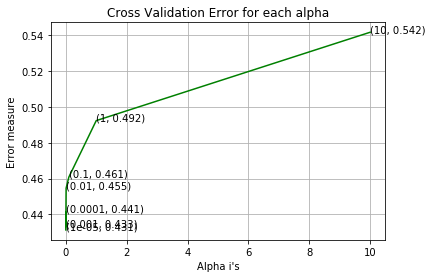

For values of best alpha =  1e-05 The train log loss is: 0.42308944025483397
For values of best alpha =  1e-05 The test log loss is: 0.43135426420798906
Total number of data points : 30000


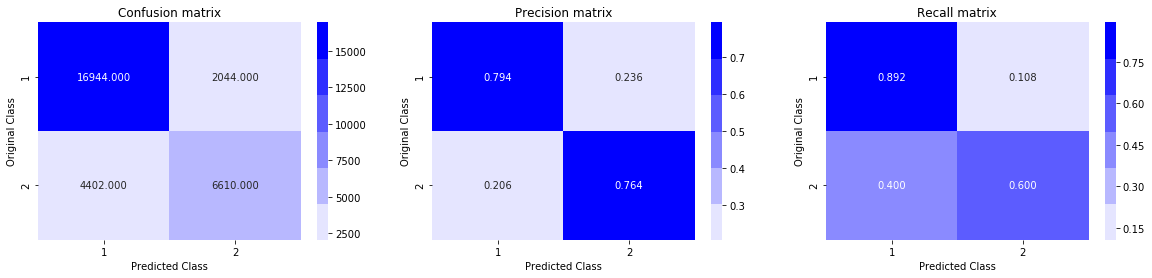

In [87]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM with TFIDF

For values of alpha =  1e-05 The log loss is: 0.4555238542254614
For values of alpha =  0.0001 The log loss is: 0.46840665545326143
For values of alpha =  0.001 The log loss is: 0.4761432467249373
For values of alpha =  0.01 The log loss is: 0.47578968050467224
For values of alpha =  0.1 The log loss is: 0.48059910448385124
For values of alpha =  1 The log loss is: 0.5762408310000736
For values of alpha =  10 The log loss is: 0.6411391261345559


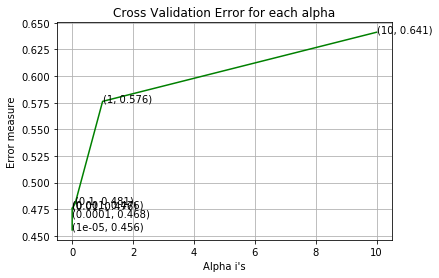

For values of best alpha =  1e-05 The train log loss is: 0.44745995632811636
For values of best alpha =  1e-05 The test log loss is: 0.4555238542254614
Total number of data points : 30000


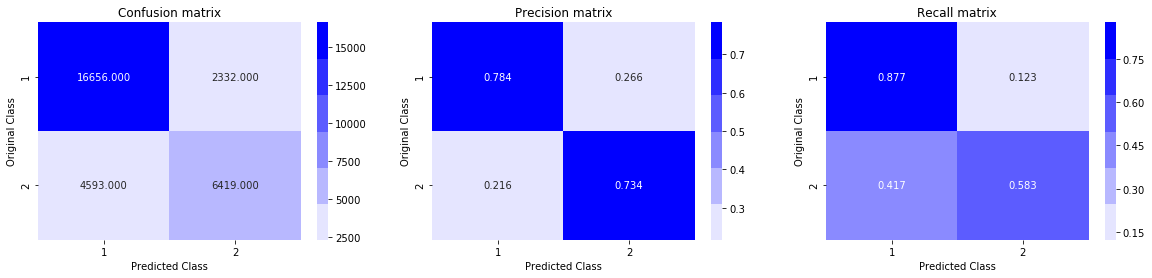

In [88]:
warnings.filterwarnings("ignore")
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost with RandomSearch

In [91]:
from sklearn.model_selection import RandomizedSearchCV

In [207]:
params = {}
params['learning_rate']=[0.05,0.1,0.15,0.20,0.25,0.3,0.35,0.4,0.45,0.5]
params['max_depth']=[1,2,3,4,5]
params['n_estimators']=[10,100,200,500,1000]
params['min_child_weight']= [1, 2, 3, 4]

In [209]:
params

{'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
 'max_depth': [1, 2, 3, 4, 5],
 'n_estimators': [10, 100, 200, 500, 1000],
 'min_child_weight': [1, 2, 3, 4]}

In [210]:
from scipy import stats

In [211]:
xgbc=xgb.XGBClassifier(eval_metric='logloss')
xgbc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [212]:
clf=RandomizedSearchCV(xgbc,params)
clf

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, re...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [213]:
%%time
search=clf.fit(X_train,y_train)

CPU times: user 6h 43min 40s, sys: 11.6 s, total: 6h 43min 52s
Wall time: 6h 43min 57s


In [214]:
params

{'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
 'max_depth': [1, 2, 3, 4, 5],
 'n_estimators': [10, 100, 200, 500, 1000],
 'min_child_weight': [1, 2, 3, 4]}

In [219]:
search.best_params_

{'n_estimators': 1000,
 'min_child_weight': 3,
 'max_depth': 4,
 'learning_rate': 0.05,
 'eval_metric': 'logloss'}

In [229]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(search.best_params_, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.6724	valid-logloss:0.67254
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.534269	valid-logloss:0.535722
[20]	train-logloss:0.464613	valid-logloss:0.467142
[30]	train-logloss:0.424555	valid-logloss:0.42797
[40]	train-logloss:0.399108	valid-logloss:0.403142
[50]	train-logloss:0.383732	valid-logloss:0.388567
[60]	train-logloss:0.373428	valid-logloss:0.379002
[70]	train-logloss:0.366315	valid-logloss:0.372469
[80]	train-logloss:0.362889	valid-logloss:0.370252
[90]	train-logloss:0.3603	valid-logloss:0.368364
[100]	train-logloss:0.357662	valid-logloss:0.368185
[110]	train-logloss:0.355726	valid-logloss:0.366135
[120]	train-logloss:0.354366	valid-logloss:0.36585
[130]	train-logloss:0.353019	valid-logloss:0.365517
Stopping. Best iteration:
[116]	train-logloss:0.354875	valid-logloss:0.365113

The test log loss is: nan


Total number of data points : 30000


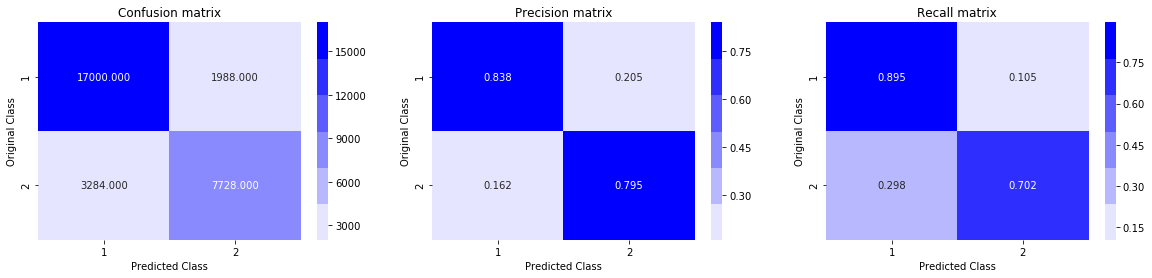

In [230]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Conclusions

For this assignment, I used only 100k data points as instructed

In this case study, the notebook had data leakage. So I split the data first, and then added the TFIDF W2V vectors before applying the models on the data.

As part of the assignment, I had to use simple TFIDF vectors instead of TFIDF W2V vectors, which slightly improved the performance of the Logistic Regression and Linear SVM models.

I used RandomizedSearchCV to tune the hyperparameters for xgboost. This ended in a very similar logloss as the original model without hyperparameter tuning.

## Summary

In [231]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
xt = PrettyTable()

column_names = ["Vectorizer", "Model", "Train logloss", "Test logloss"]

xt.add_column(column_names[0], ["TFIDFW2V", "TFIDFW2V", "TFIDFW2V", "TFIDF","TFIDF","TFIDFW2V"])
xt.add_column(column_names[1], ["Logistic Regression","Linear SVM","XGBClassifier without hyperparameter tuning","Logistic Regression","Linear SVM","XGBClassifier with hyperparameter tuning"])  
xt.add_column(column_names[2], [0.4556,0.4915,0.3482,0.4231,0.4475,0.3549])  
xt.add_column(column_names[3], [0.4584,0.4895,0.3555,0.4313,0.4555,0.3651])

print(xt)

+------------+---------------------------------------------+---------------+--------------+
| Vectorizer |                    Model                    | Train logloss | Test logloss |
+------------+---------------------------------------------+---------------+--------------+
|  TFIDFW2V  |             Logistic Regression             |     0.4556    |    0.4584    |
|  TFIDFW2V  |                  Linear SVM                 |     0.4915    |    0.4895    |
|  TFIDFW2V  | XGBClassifier without hyperparameter tuning |     0.3482    |    0.3555    |
|   TFIDF    |             Logistic Regression             |     0.4231    |    0.4313    |
|   TFIDF    |                  Linear SVM                 |     0.4475    |    0.4555    |
|  TFIDFW2V  |   XGBClassifier with hyperparameter tuning  |     0.3549    |    0.3651    |
+------------+---------------------------------------------+---------------+--------------+


__Using TFIDF vectors instead of TFIDF W2V vectors improves the performance of Logistic Regression and Linear SVM models. The evaluation metric used is log-loss.
XGBClassifier model gives us the best performance with test logloss of 0.3555__